## Performing Customer Segmentation

In [ ]:
# Import packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

### Data Preparation
* Used Signup Date feature to classify as New and Old based on date '2024-01-01'
* Calculated total spending, the number of products purchased, and the most recent transaction date for each customer.

In [ ]:
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')
products = pd.read_csv('Products.csv')

# Use personal customer information
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
customers['CustomerType'] = customers['SignupDate'].apply(lambda x: 'Old' if x < pd.Timestamp('2024-01-01') else 'New')

# Use transactions information
customer_transactions = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'ProductID': 'count',
    'TransactionDate': 'max'
}).reset_index()

customer_transactions['Recency'] = (pd.Timestamp.now() - customer_transactions['TransactionDate']).dt.days
transactions = transactions.merge(products[['ProductID', 'Category']], on='ProductID', how='left')
category_per_customer = transactions.groupby('CustomerID')['Category'].apply(lambda x: set(x)).reset_index()
category_per_customer = category_per_customer.rename(columns={'Category': 'Categories'})
customers_data = customers.merge(customer_transactions, on='CustomerID', how='left')
customers_data = customers_data.merge(category_per_customer, on='CustomerID', how='left')
# print(customers_data.isnull().sum())
customers_data['TotalValue'] = customers_data['TotalValue'].fillna(customers_data['TotalValue'].mean())
customers_data['Categories'] = customers_data['Categories'].fillna('Unknown')
customers_data['Recency'] = customers_data['Recency'].fillna(customers_data['Recency'].max())

### Feature Extraction
* Applied scaling to numerical features and one-hot encoding to categorical features.

In [ ]:
features = customers_data[['Region', 'CustomerType', 'TotalValue', 'Recency', 'Categories']]
categorical_features = ['Region', 'CustomerType']
numerical_features = ['TotalValue', 'Recency']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

### Applying K-Means

In [ ]:
X = preprocessor.fit_transform(features)
kmeans = KMeans(n_clusters=4, random_state=42)
customers_data['Cluster'] = kmeans.fit_predict(X)

# DBI Score
db_index = davies_bouldin_score(X, customers_data['Cluster'])
print(f'DBI Index: {db_index:.4f}')
# Silhouette Score
sil_score = silhouette_score(X, customers_data['Cluster'])
print(f'Silhouette Score: {sil_score:.4f}')

DBI Index: 1.3652
Silhouette Score: 0.2456


## Visualization of clusters

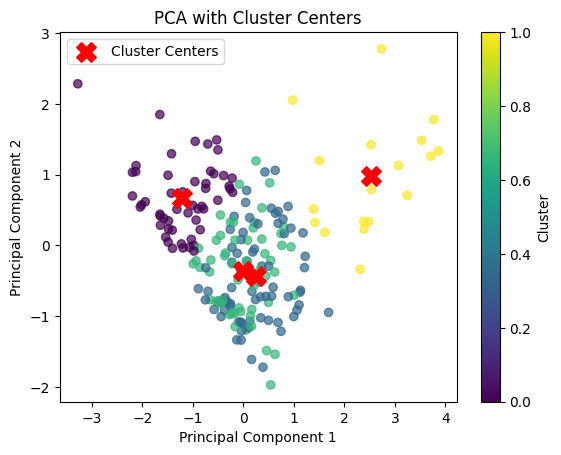

In [ ]:
# Apply PCA to reduce dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

centers = pca.transform(kmeans.cluster_centers_)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=customers_data['Cluster'], cmap='viridis', alpha=0.7)
plt.scatter(centers[:, 0], centers[:, 1], s=200, c='red', marker='X', label='Cluster Centers')
plt.title('PCA with Cluster Centers')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.legend()
plt.show()

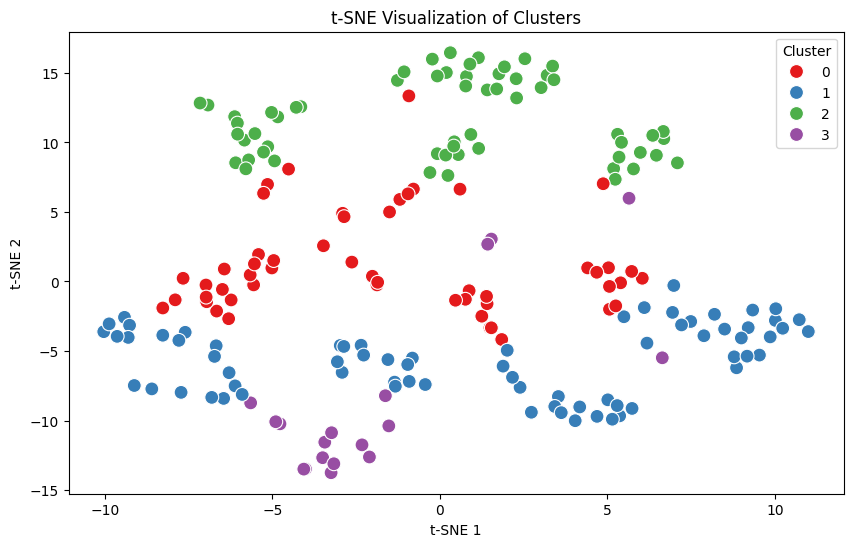

In [ ]:
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=customers_data['Cluster'], palette='Set1', s=100)
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

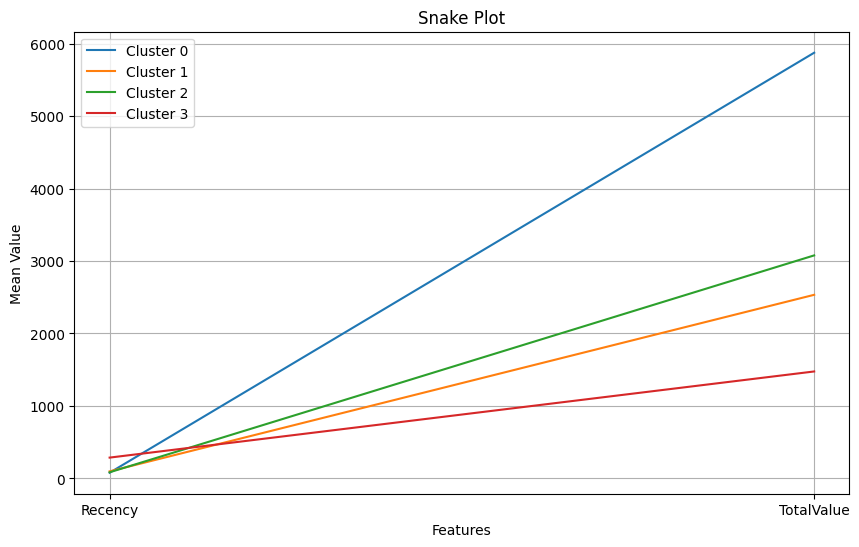

In [ ]:
# Snake Plot
cluster_means = customers_data.groupby('Cluster')[['Recency', 'TotalValue']].mean()
plt.figure(figsize=(10, 6))
for cluster in cluster_means.index:
    plt.plot(cluster_means.columns, cluster_means.loc[cluster], label=f'Cluster {cluster}')

plt.title('Snake Plot')
plt.xlabel('Features')
plt.ylabel('Mean Value')
plt.legend()
plt.grid()
plt.show()
